# 1.Imports, configs e constantes

In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 100)
sns.set(style="whitegrid")

TARGET_COL = "y"
ID_COL = "id"
TIME_COL = "safra"

# 2. Ler bases

In [116]:
df_train = pd.read_csv(r'C:\Users\Enrico\OneDrive\Documentos\Python\credit_scoring_challenge\data\processed\train.csv')
df_test  = pd.read_csv(r'C:\Users\Enrico\OneDrive\Documentos\Python\credit_scoring_challenge\data\processed\test.csv')

# 3. Missing, Constant e Id-Like

In [117]:
total_rows_train = df_train.shape[0]

summary = pd.DataFrame({
    "dtype": df_train.dtypes,
    "n_missing": df_train.isna().sum(),
    "pct_missing": df_train.isna().mean() * 100,
    "n_unique": df_train.nunique()
})

summary["is_constant"] = summary["n_unique"] == 1
summary["is_id_like"]  = summary["n_unique"] == total_rows_train

missing_threshold = 60.0  # acima desse percentual descartar

high_missing_cols = summary[summary["pct_missing"] > missing_threshold].index.tolist() 
constant_cols     = summary[summary["is_constant"]].index.tolist() # coluna com registros iguais
id_like_cols      = summary[summary["is_id_like"]].index.tolist() # coluna com muitos registros únicos

print("High missing:", len(high_missing_cols))
print("Constant:", len(constant_cols))
print("ID-like:", len(id_like_cols))

High missing: 19
Constant: 0
ID-like: 1


In [118]:
# Definindo colunas dessa etapa para dropar
protected_cols = [TARGET_COL, ID_COL, TIME_COL]

cols_to_drop_missing_constant_id = sorted(
    set(high_missing_cols + constant_cols + id_like_cols)
    - set(protected_cols)
)

len(cols_to_drop_missing_constant_id), cols_to_drop_missing_constant_id

(19,
 ['VAR_12',
  'VAR_16',
  'VAR_18',
  'VAR_21',
  'VAR_36',
  'VAR_41',
  'VAR_43',
  'VAR_47',
  'VAR_48',
  'VAR_49',
  'VAR_50',
  'VAR_55',
  'VAR_56',
  'VAR_61',
  'VAR_62',
  'VAR_63',
  'VAR_68',
  'VAR_70',
  'VAR_75'])

In [119]:
# Dropando colunas definidas
df_train1 = df_train.drop(columns=cols_to_drop_missing_constant_id)
df_test1  = df_test.drop(columns=cols_to_drop_missing_constant_id)

df_train1.shape, df_test1.shape

((8211, 62), (2527, 62))

# 4. Variância

In [120]:
# Seleciona colunas numéricas
numeric_cols = df_train1.select_dtypes(include=[np.number]).columns.tolist()

# Garante que não entra a target nem id/safra
for col in [TARGET_COL, ID_COL, TIME_COL]:
    if col in numeric_cols:
        numeric_cols.remove(col)

len(numeric_cols), numeric_cols[:10]

(59,
 ['VAR_1',
  'VAR_2',
  'VAR_3',
  'VAR_4',
  'VAR_5',
  'VAR_6',
  'VAR_7',
  'VAR_8',
  'VAR_9',
  'VAR_10'])

In [121]:
variances = df_train1[numeric_cols].var()
variances.describe()

count    5.900000e+01
mean     1.119324e+06
std      6.168565e+06
min      7.828591e-04
25%      2.808681e+01
50%      4.962752e+03
75%      9.035329e+04
max      4.707317e+07
dtype: float64

In [122]:
variances = df_train1[numeric_cols].var()

low_var_threshold = 0.001  # valor padrão
low_var_cols = variances[variances < low_var_threshold].index.tolist()

len(low_var_cols)

1

In [123]:
df_train2 = df_train1.drop(columns=low_var_cols)
df_test2  = df_test1.drop(columns=low_var_cols)

df_train2.shape, df_test2.shape

((8211, 61), (2527, 61))

# 5. Colunas duplicadas

In [124]:
# Categóricas em step2
cat_cols = df_train2.select_dtypes(include=["object", "category"]).columns.tolist()

# Garante que y/safra não entrem aqui
for col in [TARGET_COL, TIME_COL]:
    if col in cat_cols:
        cat_cols.remove(col)

len(cat_cols)

0

# 6. Muticolinearidade

In [125]:
# Matriz de correlação entre features numéricas
num_cols = df_train2.select_dtypes(include=[np.number]).columns.tolist()

for col in [TARGET_COL, ID_COL, TIME_COL]:
    if col in num_cols:
        num_cols.remove(col)

corr_matrix = df_train2[num_cols].corr().abs()

len(num_cols)

58

In [126]:
# Identificar pares com correlação maior que 0.9
upper = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
corr_pairs = corr_matrix.where(upper)

high_corr_pairs = (
    corr_pairs.stack()
              .reset_index()
              .rename(columns={"level_0": "var1", "level_1": "var2", 0: "corr"})
              .query("corr > 0.9")
              .sort_values("corr", ascending=False)
)

high_corr_pairs

,var1,var2,corr
1649,VAR_74,VAR_78,0.998554
1633,VAR_71,VAR_73,0.997062
1535,VAR_57,VAR_60,0.991046
751,VAR_19,VAR_22,0.975977
517,VAR_10,VAR_69,0.975103
935,VAR_24,VAR_58,0.974130
952,VAR_25,VAR_28,0.972608
1331,VAR_39,VAR_45,0.972208
1354,VAR_40,VAR_44,0.968908
626,VAR_14,VAR_26,0.954847


In [127]:
# Separando colunas para dropar
cols_to_drop_high_corr = sorted(set(high_corr_pairs["var2"].tolist()))
cols_to_drop_high_corr

['VAR_22',
 'VAR_26',
 'VAR_28',
 'VAR_44',
 'VAR_45',
 'VAR_58',
 'VAR_60',
 'VAR_64',
 'VAR_69',
 'VAR_73',
 'VAR_78']

In [128]:
# Dropando colunas definidas
df_train3 = df_train2.drop(columns=cols_to_drop_high_corr)
df_test3  = df_test2.drop(columns=cols_to_drop_high_corr)

df_train3.shape, df_test3.shape

((8211, 50), (2527, 50))

# 7. Estabilidade das variáveis por safra

In [129]:
# Calcula as features mais relacionadas com y
num_cols_target = df_train3.select_dtypes(include=[np.number]).columns.tolist()
for col in [TARGET_COL, ID_COL, TIME_COL]:
    if col in num_cols_target:
        num_cols_target.remove(col)

corr_with_target = df_train3[num_cols_target].corrwith(df_train3[TARGET_COL])
corr_with_target_abs = corr_with_target.abs().sort_values(ascending=False)

top_features = corr_with_target_abs.index.tolist()
top_features, corr_with_target_abs

(['VAR_1',
  'VAR_2',
  'VAR_3',
  'VAR_4',
  'VAR_20',
  'VAR_25',
  'VAR_40',
  'VAR_19',
  'VAR_57',
  'VAR_42',
  'VAR_65',
  'VAR_46',
  'VAR_14',
  'VAR_37',
  'VAR_29',
  'VAR_9',
  'VAR_17',
  'VAR_31',
  'VAR_71',
  'VAR_74',
  'VAR_33',
  'VAR_27',
  'VAR_34',
  'VAR_51',
  'VAR_72',
  'VAR_59',
  'VAR_6',
  'VAR_8',
  'VAR_38',
  'VAR_67',
  'VAR_10',
  'VAR_15',
  'VAR_76',
  'VAR_7',
  'VAR_52',
  'VAR_35',
  'VAR_23',
  'VAR_66',
  'VAR_30',
  'VAR_54',
  'VAR_24',
  'VAR_77',
  'VAR_39',
  'VAR_5',
  'VAR_11',
  'VAR_13',
  'VAR_53'],
 VAR_1     0.399575
 VAR_2     0.259327
 VAR_3     0.198855
 VAR_4     0.175292
 VAR_20    0.162410
 VAR_25    0.145410
 VAR_40    0.137743
 VAR_19    0.130683
 VAR_57    0.130064
 VAR_42    0.129590
 VAR_65    0.129115
 VAR_46    0.126344
 VAR_14    0.122777
 VAR_37    0.120690
 VAR_29    0.119699
 VAR_9     0.119101
 VAR_17    0.107004
 VAR_31    0.098124
 VAR_71    0.097453
 VAR_74    0.095330
 VAR_33    0.091721
 VAR_27    0.077451
 VAR

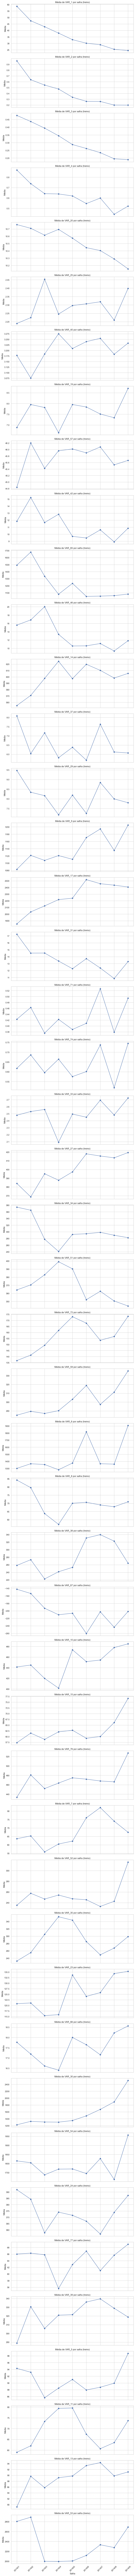

In [130]:
# Média por safra
fig, axes = plt.subplots(len(top_features), 1, figsize=(10, 4 * len(top_features)), sharex=True)

if len(top_features) == 1:
    axes = [axes]

for ax, col in zip(axes, top_features):
    tmp = df_train3.groupby(TIME_COL)[col].mean()
    ax.plot(tmp.index.astype(str), tmp.values, marker="o")
    ax.set_title(f"Média de {col} por safra (treino)")
    ax.set_ylabel("Média")
    ax.tick_params(axis="x", rotation=45)

plt.xlabel("Safra")
plt.tight_layout()
plt.show()

In [131]:
# Mediana e Quartil por safra
q_stats = (
    df_train3
    .groupby(TIME_COL)[top_features]
    .quantile([0.25, 0.5, 0.75])
    .unstack(level=-1)
)

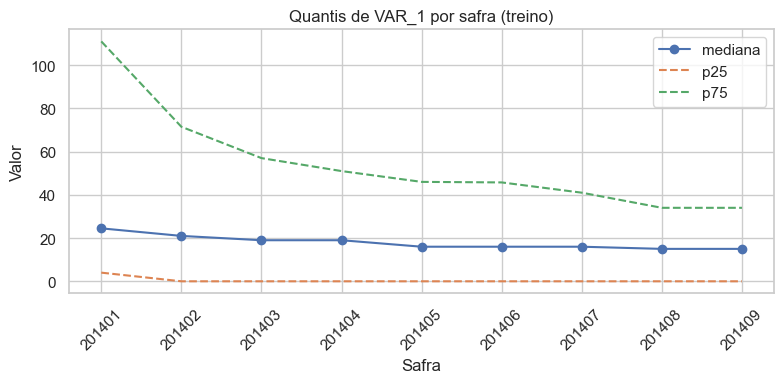

In [132]:
# Exemplo de uma variável
feat = top_features[0]

plt.figure(figsize=(8, 4))
plt.plot(q_stats.index.astype(str), q_stats[(feat, 0.5)], marker="o", label="mediana")
plt.plot(q_stats.index.astype(str), q_stats[(feat, 0.25)], linestyle="--", label="p25")
plt.plot(q_stats.index.astype(str), q_stats[(feat, 0.75)], linestyle="--", label="p75")
plt.title(f"Quantis de {feat} por safra (treino)")
plt.xlabel("Safra")
plt.ylabel("Valor")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# 8. PSI

In [133]:
def psi_for_feature(train: pd.Series, test: pd.Series, n_bins: int = 10) -> float:
    """
    Calcula o PSI de uma feature contínua/categorizada, usando bins baseados no treino.
    """
    # Remove NaN
    train = train.dropna()
    test = test.dropna()

    # Definir bins com base no treino (quantis)
    quantiles = np.linspace(0, 1, n_bins + 1)
    bin_edges = np.unique(np.quantile(train, quantiles))

    # Se der menos de 2 edges únicos, PSI = 0 (sem variação)
    if len(bin_edges) < 2:
        return 0.0

    train_bins = pd.cut(train, bins=bin_edges, include_lowest=True)
    test_bins  = pd.cut(test,  bins=bin_edges, include_lowest=True)

    train_dist = train_bins.value_counts(normalize=True).sort_index()
    test_dist  = test_bins.value_counts(normalize=True).sort_index()

    # Alinha índices
    test_dist = test_dist.reindex(train_dist.index).fillna(0.0)

    # Evitar log(0)
    epsilon = 1e-6
    train_dist = train_dist.clip(epsilon, 1)
    test_dist  = test_dist.clip(epsilon, 1)

    psi_values = (train_dist - test_dist) * np.log(train_dist / test_dist)
    return float(psi_values.sum())


def psi_for_dataframe(
    df_train: pd.DataFrame,
    df_test: pd.DataFrame,
    feature_cols: list[str],
    n_bins: int = 10,
) -> pd.Series:
    psi_dict = {}
    for col in feature_cols:
        psi_dict[col] = psi_for_feature(df_train[col], df_test[col], n_bins=n_bins)
    return pd.Series(psi_dict).sort_values(ascending=False)

In [134]:
# Calcular PSI para features numéricas
num_cols_fe = df_train3.select_dtypes(include=[np.number]).columns.tolist()
for col in [TARGET_COL, ID_COL, TIME_COL]:
    if col in num_cols_fe:
        num_cols_fe.remove(col)

psi_values = psi_for_dataframe(df_train3, df_test3, num_cols_fe, n_bins=10)
psi_values.head(20)

VAR_30    0.201377
VAR_1     0.114739
VAR_27    0.085693
VAR_17    0.083235
VAR_52    0.076833
VAR_15    0.070507
VAR_53    0.069508
VAR_14    0.062152
VAR_2     0.055506
VAR_51    0.051285
VAR_31    0.030933
VAR_37    0.029473
VAR_38    0.025040
VAR_6     0.023270
VAR_5     0.020802
VAR_4     0.018074
VAR_59    0.017588
VAR_29    0.017382
VAR_23    0.017316
VAR_46    0.016887
dtype: float64

PSI < 0.1 → estável

0.1 ≤ PSI < 0.25 → moderada mudança

PSI ≥ 0.25 → forte mudança de distribuição

In [135]:
high_psi_cols = psi_values[psi_values >= 0.25].index.tolist()
medium_psi_cols = psi_values[(psi_values >= 0.1) & (psi_values < 0.25)].index.tolist()

len(high_psi_cols), len(medium_psi_cols)

(0, 2)

In [136]:
# Garantir a igualdade da base
set(df_train3.columns) == set(df_train3.columns)

True

In [137]:
df_train3.to_csv(r'C:\Users\Enrico\OneDrive\Documentos\Python\credit_scoring_challenge\data\processed\train_fe.csv', index=False)
df_test3.to_csv(r'C:\Users\Enrico\OneDrive\Documentos\Python\credit_scoring_challenge\data\processed\test_fe.csv', index=False)